In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batchSize = 200

trainset, validateset = random_split(dataset, [45000, 5000])

train = DataLoader(trainset, batchSize, shuffle=True)
validate = DataLoader(validateset, batchSize, shuffle=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

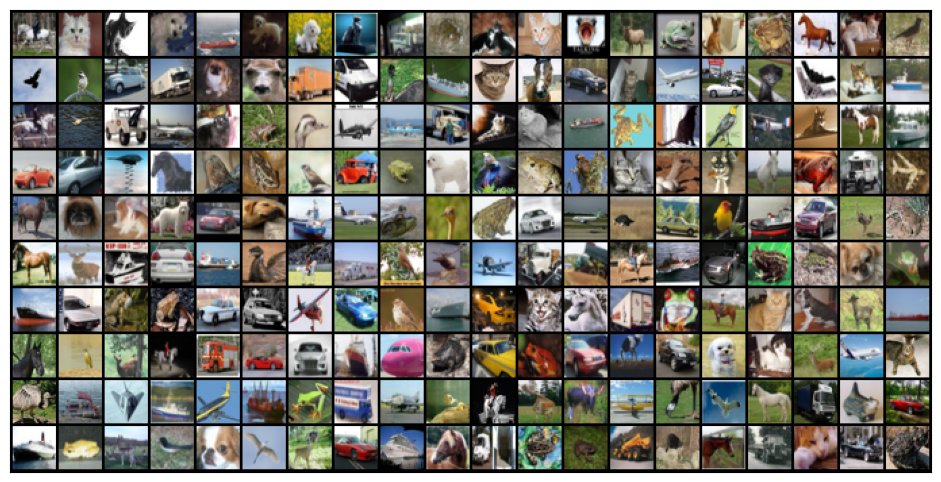

In [6]:
for images, labels in train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break

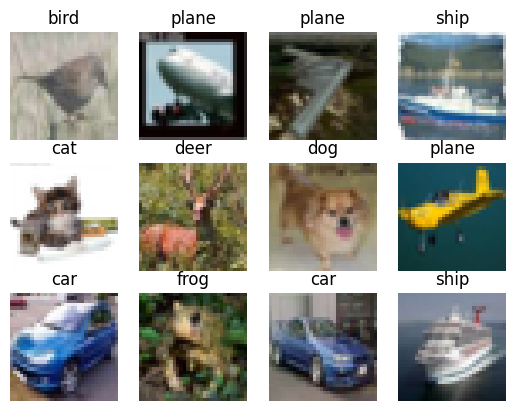

In [7]:
for i in range(0, 12):
    img, label = validateset[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

In [8]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(

            # here we define 3 channels as our inpur, 32 channels as the output,
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
             nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch):
        # unpack the images and labels from the
        images, labels = batch

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
              _, preds = torch.max(outputs, dim=1)
              return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)


In [9]:
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [10]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    optimizer = optimizationFunction(model.parameters(), lr)

    for epoch in range(epochs):
        print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainingLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")

In [11]:
# instantiate the model
model = Cifar10Classifier()
# do an evaluation of the model on the tra
evaluateModel(model, validate)

{'loss': 2.3028290271759033, 'accuracy': 0.10760000348091125}

In [12]:
%%time
trainModel(10, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

training epoch 0
after training epoch 0 we get results {'loss': 1.6187442541122437, 'accuracy': 0.3985999822616577}
training epoch 1
after training epoch 1 we get results {'loss': 1.2636058330535889, 'accuracy': 0.5329999923706055}
training epoch 2
after training epoch 2 we get results {'loss': 1.0379900932312012, 'accuracy': 0.6233999729156494}
training epoch 3
after training epoch 3 we get results {'loss': 0.888074517250061, 'accuracy': 0.6906000375747681}
training epoch 4
after training epoch 4 we get results {'loss': 0.8348971009254456, 'accuracy': 0.6999999284744263}
training epoch 5
after training epoch 5 we get results {'loss': 0.7819455862045288, 'accuracy': 0.7242000102996826}
training epoch 6
after training epoch 6 we get results {'loss': 0.74527907371521, 'accuracy': 0.7489999532699585}
training epoch 7
after training epoch 7 we get results {'loss': 0.7496823668479919, 'accuracy': 0.7508000135421753}
training epoch 8
after training epoch 8 we get results {'loss': 0.732717752

In [13]:
print(f"validation dataset accuracy: {evaluateModel(model, validate)}")


validation dataset accuracy: {'loss': 0.7618021965026855, 'accuracy': 0.7642000317573547}


In [14]:
print(f"test dataset accuracy: {evaluateModel(model, testLoader)}")

test dataset accuracy: {'loss': 0.7927024960517883, 'accuracy': 0.749500036239624}


In [20]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

/tmp/ipykernel_121/555298138.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i + 1)


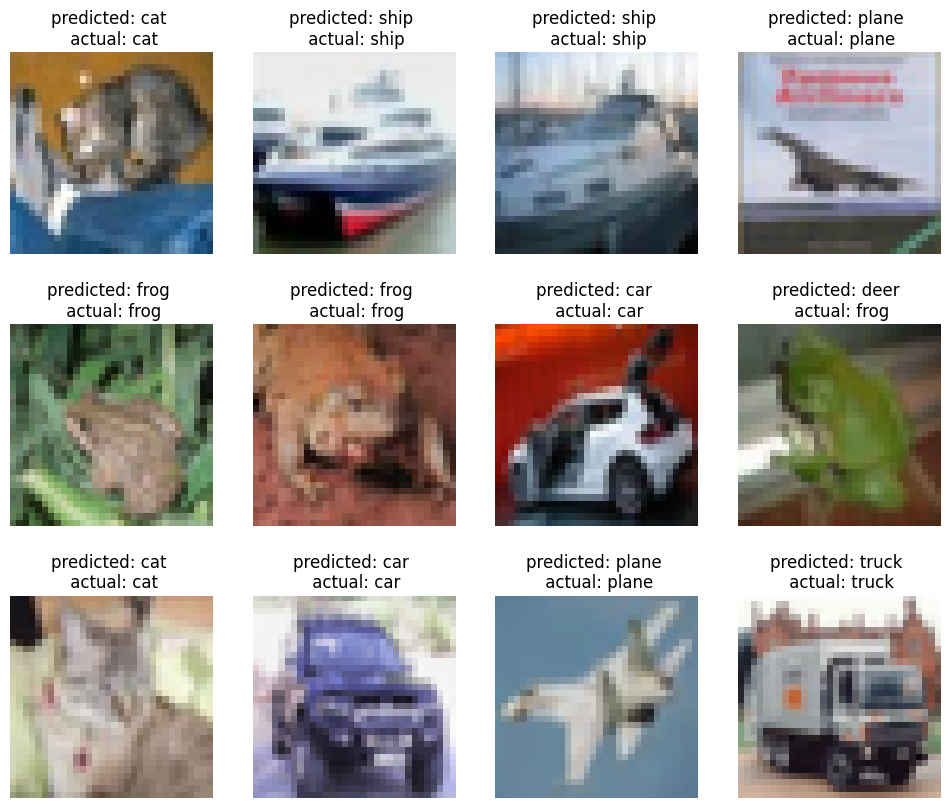

In [21]:
with torch.no_grad():
    
    plt.subplots(figsize=(12, 10))
    
    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)
        
        
        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))